Test set evaluation

In [2]:
from ast import literal_eval
import logging
import os
import random

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from datasets import Dataset
import numpy as np
import pandas as pd
import spacy
import torch
from torch.utils.data import DataLoader
import torchmetrics
from tqdm import tqdm


import sys
sys.path.append("/home/hermione/Documents/VLP/TUM/rgrg_pretrained/")
from src.dataset.constants import ANATOMICAL_REGIONS
from src.full_model.custom_collator import CustomCollator
from src.full_model.custom_dataset import CustomDataset
from src.full_model.evaluate_full_model.evaluate_language_model import (
    compute_language_model_scores
)
from src.full_model.report_generation_model import ReportGenerationModel
from src.full_model.train_full_model import get_tokenizer
from src.path_datasets_and_weights import path_full_dataset, path_runs_full_model, path_test_set_evaluation_scores_txt_files

# specify the checkpoint you want to evaluate by setting "RUN" and "CHECKPOINT"
RUN = 20
CHECKPOINT = "checkpoint_val_loss_1.778_overall_steps_501150.pt" #src/runs/full_model/run_20/checkpoints/
BERTSCORE_SIMILARITY_THRESHOLD = 0.9
IMAGE_INPUT_SIZE = 512
BATCH_SIZE = 8
NUM_WORKERS = 10
NUM_BEAMS = 4
MAX_NUM_TOKENS_GENERATE = 300
NUM_BATCHES_OF_GENERATED_SENTENCES_TO_SAVE_TO_FILE = 100
NUM_BATCHES_OF_GENERATED_REPORTS_TO_SAVE_TO_FILE = 100

# set the seed value for reproducibility
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

"""
Folder specified by path_test_set_evaluation_scores_txt_files will have these files after test set evaluation:

    - final_scores.txt
    - generated_sentences.txt
    - generated_abnormal_sentences.txt
    - generated_reports.txt
"""
final_scores_txt_file = os.path.join(path_test_set_evaluation_scores_txt_files, "final_scores.txt")

device:  cuda:1
device:  cuda:1


# Test set examples

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

test = pd.read_csv("/home/hermione/Documents/data/rgrg/dataset-with-reference-reports/test.csv")
chexpert = pd.read_csv("/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-chexpert.csv")
test = test.sample(n=len(test), random_state=42)
test_chex = pd.merge(test, chexpert, on=['subject_id', 'study_id'])
test_subset = test[test_chex["No Finding"] == 1]
test = test.reset_index()
test_subset

/tmp/ipykernel_576955/1501026630.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_subset = test[test_chex["No Finding"] == 1]


,subject_id,study_id,image_id,mimic_image_file_path,reference_report
9720,12881570,55397915,7f98ce07-544a6980-c6490754-d9c0a644-5c4b781e,/home/hermione/Documents/data/physionet.org/fi...,"The cardiac, mediastinal and hilar contours ar..."
3110,10940236,54578565,2e99d6a9-b9c5c86a-e80700e0-8f88103b-c9bd21a2,/home/hermione/Documents/data/physionet.org/fi...,The patient has had median sternotomy with val...
5894,11783844,57887027,ef4c4aff-be758748-834669fd-a0d312d4-16d17c89,/home/hermione/Documents/data/physionet.org/fi...,The patient is rotated. The ETT tip projects a...
9194,12690341,57299502,5fdf9af9-b4a0ed8a-af2b450f-cf16a77c-e3132710,/home/hermione/Documents/data/physionet.org/fi...,The lungs are clear without focal consolidatio...
3100,10934419,54327896,955fdf1d-6d7e83e5-6950bacc-1e32a01f-fbd4d95f,/home/hermione/Documents/data/physionet.org/fi...,PA and lateral views of the chest are provided...
...,...,...,...,...,...
4426,11341217,51641002,e7e947df-62d17968-ec65da12-edf2d9d1-800fa0e0,/home/hermione/Documents/data/physionet.org/fi...,There increased bilateral infiltrates right gr...
466,10141577,57173218,9601b43b-3b774fbe-b3f2cc0f-0779a8b0-a083047c,/home/hermione/Documents/data/physionet.org/fi...,Sternotomy wires are intact and mitral valve r...
5191,11584231,57128625,0764a4ce-12cbb8cc-0eedc481-c55826d3-56217e7a,/home/hermione/Documents/data/physionet.org/fi...,Endotracheal tube terminates approximately 2.3...
5390,11629754,54271090,b3510789-01f1fb0e-1ae7ec3a-935f6349-967c864a,/home/hermione/Documents/data/physionet.org/fi...,No definite focal consolidation is seen. No pl...


In [23]:
test[:8]

,index,subject_id,study_id,image_id,mimic_image_file_path,reference_report
0,9720,12881570,55397915,7f98ce07-544a6980-c6490754-d9c0a644-5c4b781e,/home/hermione/Documents/data/physionet.org/fi...,"The cardiac, mediastinal and hilar contours ar..."
1,3110,10940236,54578565,2e99d6a9-b9c5c86a-e80700e0-8f88103b-c9bd21a2,/home/hermione/Documents/data/physionet.org/fi...,The patient has had median sternotomy with val...
2,5992,11808646,57770926,5ba3d7fa-f007c69d-e4031fdb-fa9ab27e-6e1711c6,/home/hermione/Documents/data/physionet.org/fi...,PA frontal and lateral chest radiographs demon...
3,5894,11783844,57887027,ef4c4aff-be758748-834669fd-a0d312d4-16d17c89,/home/hermione/Documents/data/physionet.org/fi...,The patient is rotated. The ETT tip projects a...
4,2615,10758378,57117249,7b772752-1b38c380-fd618761-67ef0c52-931badb9,/home/hermione/Documents/data/physionet.org/fi...,PA and lateral views of the chest were provide...
5,510,10150746,56940896,2eaf7963-b02a0948-243e2dd6-93303477-1bd5da5a,/home/hermione/Documents/data/physionet.org/fi...,The lungs appear clear. The cardiomediastinal ...
6,9194,12690341,57299502,5fdf9af9-b4a0ed8a-af2b450f-cf16a77c-e3132710,/home/hermione/Documents/data/physionet.org/fi...,The lungs are clear without focal consolidatio...
7,169,10028480,52938334,c27a1062-28dd3d19-4ae26205-b69741bb-b479f705,/home/hermione/Documents/data/physionet.org/fi...,There is no evidence of pneumothorax or pleura...


/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p12/p12690341/s57299502/5fdf9af9-b4a0ed8a-af2b450f-cf16a77c-e3132710.jpg
The lungs are clear without focal consolidation. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.


(-0.5, 2543.5, 3055.5, -0.5)

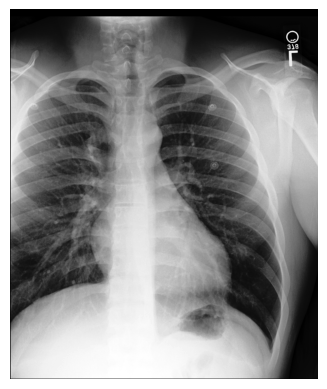

In [28]:
#path = "/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p12881570/s55397915/7f98ce07-544a6980-c6490754-d9c0a644-5c4b781e.jpg"
#path = test["mimic_image_file_path"][9720]
#test = test.reset_index()
path = test["mimic_image_file_path"][6]
print(path)
print(test["reference_report"][6])
image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
plt.imshow(image, cmap='gray')
plt.axis("off")

In [33]:
l=[0.88295,0.89628,0.04775,0.82488,0.97576,0.00000,0.74874,0.00000,0.98689,0.89911,0.86872,0.24533,0.96900,0.35655]
def av(l):
    av = sum(l)/len(l)
    return av

print(av(l))
print(np.mean(l))

0.6215685714285714
0.6215685714285714


In [ ]:
eport_CE_enlarged_cardiomediastinum_precision: 0.88295
report_CE_enlarged_cardiomediastinum_recall: 0.93784
report_CE_enlarged_cardiomediastinum_f1: 0.90956
report_CE_enlarged_cardiomediastinum_acc: 0.83591
report_CE_cardiomegaly_precision: 0.89628
report_CE_cardiomegaly_recall: 0.26853
report_CE_cardiomegaly_f1: 0.41325
report_CE_cardiomegaly_acc: 0.38573
report_CE_lung_opacity_precision: 0.04775
report_CE_lung_opacity_recall: 0.03352
report_CE_lung_opacity_f1: 0.03939
report_CE_lung_opacity_acc: 0.91347
report_CE_lung_lesion_precision: 0.82488
report_CE_lung_lesion_recall: 0.88747
report_CE_lung_lesion_f1: 0.85503
report_CE_lung_lesion_acc: 0.75067
report_CE_edema_precision: 0.97576
report_CE_edema_recall: 1.00000
report_CE_edema_f1: 0.98773
report_CE_edema_acc: 0.97576
report_CE_consolidation_precision: 0.00000
report_CE_consolidation_recall: 0.00000
report_CE_consolidation_f1: 0.00000
report_CE_consolidation_acc: 0.99990
report_CE_pneumonia_precision: 0.74874
report_CE_pneumonia_recall: 0.95800
report_CE_pneumonia_f1: 0.84054
report_CE_pneumonia_acc: 0.72790
report_CE_atelectasis_precision: 0.00000
report_CE_atelectasis_recall: 0.00000
report_CE_atelectasis_f1: 0.00000
report_CE_atelectasis_acc: 0.99724
report_CE_pneumothorax_precision: 0.98689
report_CE_pneumothorax_recall: 1.00000
report_CE_pneumothorax_f1: 0.99340
report_CE_pneumothorax_acc: 0.98689
report_CE_pleural_effusion_precision: 0.89911
report_CE_pleural_effusion_recall: 0.98135
report_CE_pleural_effusion_f1: 0.93843
report_CE_pleural_effusion_acc: 0.88430
report_CE_pleural_other_precision: 0.86872
report_CE_pleural_other_recall: 0.96461
report_CE_pleural_other_f1: 0.91415
report_CE_pleural_other_acc: 0.84261
report_CE_fracture_precision: 0.24533
report_CE_fracture_recall: 0.33921
report_CE_fracture_f1: 0.28473
report_CE_fracture_acc: 0.59003
report_CE_support_devices_precision: 0.96900
report_CE_support_devices_recall: 0.80134
report_CE_support_devices_f1: 0.87723
report_CE_support_devices_acc: 0.78269
report_CE_no_finding_precision: 0.35655
report_CE_no_finding_recall: 0.14536
report_CE_no_finding_f1: 0.20652
report_CE_no_finding_acc: 0.51532
report_CE_precision_example_all: 0.76231
report_CE_recall_example_all: 0.75693
report_CE_f1_example_all: 0.74111
report_CE_acc_example_all: 0.82563
report_CE_f1_micro_all: 0.83471